In [9]:
!pip -q install pybboxes
!pip -q install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.2/812.2 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 68.5 MB/s eta 0:00:00


In [29]:
import cv2
import numpy as np
import os
import pandas as pd
import pickle
from tqdm.auto import tqdm
import pybboxes as pybbx
from matplotlib import pyplot as plt
import math
import copy


import torch
from torch.utils.data import Dataset
from torch import nn
from torch.nn import functional as F

from torchvision.models import resnet
import torchvision.transforms as transforms
from torchmetrics import Accuracy

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger, TensorBoardLogger


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
UCODE_DICT = '/content/drive/MyDrive/Resource/Data/HWDB1.1-bitmap64-ucode-hannom-v2-tst_seen-label-set-ucode.pkl'

# Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/
# !pip install kaggle
!mkdir -v ~/.kaggle

!cp -f "/content/drive/MyDrive/Thesis Resource/kaggle.json" ~/.kaggle
!kaggle datasets download -d ngcthunhb/nomdataset-crops


/content
mkdir: created directory '/root/.kaggle'
Dataset URL: https://www.kaggle.com/datasets/ngcthunhb/nomdataset-crops
License(s): unknown
 97% 177M/182M [00:06<00:00, 36.8MB/s]
100% 182M/182M [00:06<00:00, 30.1MB/s]


In [ ]:
!unzip -q /content/nomdataset-crops.zip -d dataset/

## NomImageDataset - For loading raw-cropped images

In [34]:
# Dataset class for inputting YoloV5
class NomImageDataset(Dataset):
    def __init__(self, image_dir, annotation_file, unicode_dict_path, image_size=(224, 224), transform=None):
        self.root_dir = image_dir
        self.label_list = list()
        self.image_list = list()
        self.unicode_dict = dict()
        self.transform = transform
        self.image_size = image_size
        self.n_crop = 0

        with open(unicode_dict_path, 'rb') as f:
            tmp = pickle.load(f)
            tmp = sorted(list(tmp.keys()))
        for idx, k in enumerate(tmp):
            self.unicode_dict[k] = idx

        with open(annotation_file, 'r') as f:
            for line in tqdm(f):
                line = line.strip().split(',')
                image_name, label = line
                label = label.strip()
                image_path = os.path.join(self.root_dir, image_name)

                self.image_list.append(image_path)
                try:
                    self.label_list.append(self.unicode_dict[label])
                except:
                    self.label_list.append(self.unicode_dict['UNK'])
                    # print(f'Unknown label: {label}')

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        x_image = cv2.imread(self.image_list[idx])
        y_label = self.label_list[idx]
        x_image = cv2.cvtColor(x_image, cv2.COLOR_BGR2RGB)

        if self.transform:
            x_image = self.transform(x_image)
        else:
            x_image = x_image *  1.0 / 255
            x_image = cv2.resize(x_image, self.image_size, interpolation=cv2.INTER_LANCZOS4)
            # x_image = (x_image - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
            x_image = torch.from_numpy(x_image).permute(2, 0, 1).float()
        y_label = torch.tensor(y_label, dtype=torch.long)
        return x_image, y_label

# opt = dict(
#     image_dir = '../NomDataset/datasets/mono-domain-datasets/tale-of-kieu/1871/1871-raw-images',
#     annotation_file = '../TempResources/ToK1871.txt',
#     unicode_dict_path = '../NomDataset/HWDB1.1-bitmap64-ucode-hannom-v2-tst-label-set-ucode.pkl',
#     transform = None,
# )
# dataset = NomImageDataset(**opt)

# from matplotlib import pyplot as plt
# img = dataset[2][0]
# detBoxes = dataset[2][1]


# textLabel = []
# for box in detBoxes:
#     x_tl, y_tl, x_br, y_br, label = box
#     cv2.rectangle(img, (x_tl, y_tl), (x_br, y_br), (0, 255, 0), 2)
#     cv2.putText(img, label, (x_tl, y_tl), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
#     textLabel.append(chr(int(label, 16)))
# plt.imshow(img)
# plt.show()

# print(textLabel)

class ImageCropDataset(Dataset):
    """ Image Crop Dataset Loader, used for loading Crop images and labels of crop image

    Args:
        crop_path (str): Path to the directory containing the crop images.
        label_path (str): Path to the file containing the labels of the crop images.
        input_size (tuple(int, int)): Image size to return.
        ucode_dict_path (str): Path to the file containing the unicode dictionary. For translate unicode to dictionary index
        transforms (Callable): Transforms to apply to the crop images.

    """
    def __init__(self, crop_path : str, label_path : str, input_size, ucode_dict : dict, transforms):
        self.crop_path = crop_path
        self.label_path = label_path
        self.ucode_dict = ucode_dict
        self.transforms = transforms

        self.input_size = input_size
        self.num_labels = 0

        self.crop_list = []
        self.labels_list = []

        def read_crop_and_label(crop_path, label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    line = line.split(', ')
                    self.labels_list.append(line[1].strip())
                    crop = line[0].strip()
                    # Check path exists
                    if not os.path.exists(os.path.join(crop_path, crop)):
                        raise FileNotFoundError(f'Crop image {os.path.join(crop_path, crop)} not found')
                    else:
                        self.crop_list.append(crop)

        read_crop_and_label(crop_path, label_path)

        assert self.crop_list is not None, 'No crop images found'
        assert self.labels_list is not None, 'No labels found'
        assert self.ucode_dict is not None, 'No unicode dictionary found'
        assert len(self.crop_list) == len(self.labels_list), 'Number of crops and labels do not match'

        # Display statistics of dataset
        print(f'Number of crops: {len(self.crop_list)}')
        print(f'Number of labels: {self.num_labels}')
        print(f'Crop images shape: {self.input_size}')
        print(f'Number of unique labels: {len(self.ucode_dict)}')

    def __len__(self):
        return len(self.crop_list)

    def __getitem__(self, idx):
        assert idx < len(self), 'Index out of range'
        img_path = os.path.join(self.crop_path, self.crop_list[idx])
        x_crop_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        h, w, _ = x_crop_img.shape
        if (h, w) != self.input_size:
            x_crop_img = cv2.resize(x_crop_img, self.input_size, cv2.INTER_LANCZOS4)

        if transforms is not None:
            x_crop_img = self.transforms(x_crop_img).float()
        else:
            x_crop_img = torch.tensor(x_crop_img).float()

        y_label = self.labels_list[idx]
        try:
            y_label = self.ucode_dict[y_label]
        except KeyError:
            # TODO: Handle unknown labels, cuz current dict does not have all Sino-Nom ucode
            y_label = self.ucode_dict['UNK']
        y_label = torch.tensor(y_label, dtype=torch.long)

        return x_crop_img, y_label

class ImageCropDataModule(pl.LightningDataModule):
    def __init__(self, data_dirs : dict, ucode_dict_path : str, input_size, batch_size : int, num_workers : int, transforms=None):
        super().__init__()
        self.data_dir = data_dirs
        self.ucode_dict_path = ucode_dict_path
        
        self.input_size = input_size
        self.transforms = transforms

        self.batch_size = batch_size
        self.num_workers = num_workers
        
        def read_ucode_dict(ucode_dict_path):
            with open(ucode_dict_path, 'rb') as f:
                ucode_dict = pickle.load(f)
            for i, (k, v) in enumerate(ucode_dict.items()):
                ucode_dict[k] = i
            return ucode_dict
        self.ucode_dict = read_ucode_dict(ucode_dict_path)

    def setup(self, stage=None):
        if stage == 'fit':
            self.train_dataset = ImageCropDataset(self.data_dir['train'][0], self.data_dir['train'][1], self.input_size, self.ucode_dict, self.transforms)
            self.val_dataset = ImageCropDataset(self.data_dir['val'][0], self.data_dir['val'][1], self.input_size, self.ucode_dict, self.transforms)
        elif stage == 'test':
            self.test_dataset = ImageCropDataset(self.data_dir['test'][0], self.data_dir['test'][1], self.input_size, self.ucode_dict, self.transforms)
        elif stage is None:
            pass
        else:
            raise ValueError(f"Stage {stage} not recognized")


    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False)

# Architectures

## Recognizer : Nom_Resnet101

In [ ]:
class Nom_Resnet101(nn.Module):
    def __init__(self, n_classes, pretrained=True):
        super(Nom_Resnet101, self).__init__()
        self.model = resnet.resnet101(weights=resnet.ResNet101_Weights.DEFAULT)

        # Modify the last layer
        self.model.fc = nn.Linear(self.model.fc.in_features, n_classes)

    def forward(self, x):
        return self.model(x)

class PytorchResNet101(pl.LightningModule):
    def __init__(self, num_labels):
        super(PytorchResNet101, self).__init__()
        self.save_hyperparameters()
        self.num_labels = num_labels

        # Get ResNet architecture and remove the last FC layer
        backbone = resnet.resnet101(weights=resnet.ResNet101_Weights.DEFAULT)
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]

        # Initialize layers
        self.feature_extractor = nn.Sequential(*layers)
        self.flatten = nn.Flatten()
        self.classifier = nn.Linear(num_filters, self.num_labels)

        self.criterion = nn.CrossEntropyLoss()
        self.metrics = Accuracy(task="multiclass", num_classes=self.num_labels)

        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

## Super-Resolution Generator: RRDB

In [ ]:
import torch
from torch import nn as nn
from torch.nn import functional as F
from torch.nn import init as init
from torch.nn.modules.batchnorm import _BatchNorm

@torch.no_grad()
def default_init_weights(module_list, scale=1, bias_fill=0, **kwargs):
    """Initialize network weights.

    Args:
        module_list (list[nn.Module] | nn.Module): Modules to be initialized.
        scale (float): Scale initialized weights, especially for residual
            blocks. Default: 1.
        bias_fill (float): The value to fill bias. Default: 0
        kwargs (dict): Other arguments for initialization function.
    """
    if not isinstance(module_list, list):
        module_list = [module_list]
    for module in module_list:
        for m in module.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, **kwargs)
                m.weight.data *= scale
                if m.bias is not None:
                    m.bias.data.fill_(bias_fill)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, **kwargs)
                m.weight.data *= scale
                if m.bias is not None:
                    m.bias.data.fill_(bias_fill)
            elif isinstance(m, _BatchNorm):
                init.constant_(m.weight, 1)
                if m.bias is not None:
                    m.bias.data.fill_(bias_fill)

def make_layer(basic_block, num_basic_block, **kwarg):
    """Make layers by stacking the same blocks.

    Args:
        basic_block (nn.module): nn.module class for basic block.
        num_basic_block (int): number of blocks.

    Returns:
        nn.Sequential: Stacked blocks in nn.Sequential.
    """
    layers = []
    for _ in range(num_basic_block):
        layers.append(basic_block(**kwarg))
    return nn.Sequential(*layers)

def pixel_unshuffle(x, scale):
    """ Pixel unshuffle.

    Args:
        x (Tensor): Input feature with shape (b, c, hh, hw).
        scale (int): Downsample ratio.

    Returns:
        Tensor: the pixel unshuffled feature.
    """
    b, c, hh, hw = x.size()
    out_channel = c * (scale**2)
    assert hh % scale == 0 and hw % scale == 0
    h = hh // scale
    w = hw // scale
    x_view = x.view(b, c, h, scale, w, scale)
    return x_view.permute(0, 1, 3, 5, 2, 4).reshape(b, out_channel, h, w)



class ResidualDenseBlock(nn.Module):
    """Residual Dense Block.

    Used in RRDB block in ESRGAN.

    Args:
        num_feat (int): Channel number of intermediate features.
        num_grow_ch (int): Channels for each growth.
    """

    def __init__(self, num_feat=64, num_grow_ch=32):
        super(ResidualDenseBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_feat, num_grow_ch, 3, 1, 1)
        self.conv2 = nn.Conv2d(num_feat + num_grow_ch, num_grow_ch, 3, 1, 1)
        self.conv3 = nn.Conv2d(num_feat + 2 * num_grow_ch, num_grow_ch, 3, 1, 1)
        self.conv4 = nn.Conv2d(num_feat + 3 * num_grow_ch, num_grow_ch, 3, 1, 1)
        self.conv5 = nn.Conv2d(num_feat + 4 * num_grow_ch, num_feat, 3, 1, 1)

        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

        # initialization
        default_init_weights([self.conv1, self.conv2, self.conv3, self.conv4, self.conv5], 0.1)

    def forward(self, x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(torch.cat((x, x1), 1)))
        x3 = self.lrelu(self.conv3(torch.cat((x, x1, x2), 1)))
        x4 = self.lrelu(self.conv4(torch.cat((x, x1, x2, x3), 1)))
        x5 = self.conv5(torch.cat((x, x1, x2, x3, x4), 1))
        # Empirically, we use 0.2 to scale the residual for better performance
        return x5 * 0.2 + x


class RRDB(nn.Module):
    """Residual in Residual Dense Block.

    Used in RRDB-Net in ESRGAN.

    Args:
        num_feat (int): Channel number of intermediate features.
        num_grow_ch (int): Channels for each growth.
    """

    def __init__(self, num_feat, num_grow_ch=32):
        super(RRDB, self).__init__()
        self.rdb1 = ResidualDenseBlock(num_feat, num_grow_ch)
        self.rdb2 = ResidualDenseBlock(num_feat, num_grow_ch)
        self.rdb3 = ResidualDenseBlock(num_feat, num_grow_ch)

    def forward(self, x):
        out = self.rdb1(x)
        out = self.rdb2(out)
        out = self.rdb3(out)
        # Empirically, we use 0.2 to scale the residual for better performance
        return out * 0.2 + x


class RRDBNet(nn.Module):
    """Networks consisting of Residual in Residual Dense Block, which is used
    in ESRGAN.

    ESRGAN: Enhanced Super-Resolution Generative Adversarial Networks.

    We extend ESRGAN for scale x2 and scale x1.
    Note: This is one option for scale 1, scale 2 in RRDBNet.
    We first employ the pixel-unshuffle (an inverse operation of pixelshuffle to reduce the spatial size
    and enlarge the channel size before feeding inputs into the main ESRGAN architecture.

    Args:
        num_in_ch (int): Channel number of inputs.
        num_out_ch (int): Channel number of outputs.
        num_feat (int): Channel number of intermediate features.
            Default: 64
        num_block (int): Block number in the trunk network. Defaults: 23
        num_grow_ch (int): Channels for each growth. Default: 32.
    """

    def __init__(self, num_in_ch, num_out_ch, scale=4, num_feat=64, num_block=23, num_grow_ch=32):
        super(RRDBNet, self).__init__()
        self.scale = scale
        if scale == 2:
            num_in_ch = num_in_ch * 4
        elif scale == 1:
            num_in_ch = num_in_ch * 16
        self.conv_first = nn.Conv2d(num_in_ch, num_feat, 3, 1, 1)
        self.body = make_layer(RRDB, num_block, num_feat=num_feat, num_grow_ch=num_grow_ch)
        self.conv_body = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
        # upsample
        self.conv_up1 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
        self.conv_up2 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
        self.conv_hr = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
        self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)

        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        if self.scale == 2:
            feat = pixel_unshuffle(x, scale=2)
        elif self.scale == 1:
            feat = pixel_unshuffle(x, scale=4)
        else:
            feat = x
        feat = self.conv_first(feat)
        body_feat = self.conv_body(self.body(feat))
        feat = feat + body_feat
        # upsample
        feat = self.lrelu(self.conv_up1(F.interpolate(feat, scale_factor=2, mode='nearest')))
        feat = self.lrelu(self.conv_up2(F.interpolate(feat, scale_factor=2, mode='nearest')))
        out = self.conv_last(self.lrelu(self.conv_hr(feat)))
        return out

# Training Resnet with SR images

In [ ]:
from data.NomDataset import ImageCropDataModule

opt = dict(
    name='ToK1871_SR-RealESRGANx4_RealCE',
    max_epochs=100,
    model_mode='train',
    data_dirs=dict(
        train=[
            'ToK1871/ToK1871_mixedSR_crops', 
            'ToK1871/ToK1871_mixedSR_crops.txt'
        ],
        val=[
            'ToK1902/ToK1902_SR_crops/Real-ESRGAN/RealESRGAN_x4plus',
            'ToK1902/ToK1902_crops.txt'
        ],
        test=[
            'LVT/LVT_SR_crops/Real-ESRGAN/RealESRGAN_x4plus',
            'LVT/LVT_crops.txt'
        ]
    ),
    ucode_dict_path='E:/Datasets/NomDataset/HWDB1.1-bitmap64-ucode-hannom-v2-tst_seen-label-set-ucode.pkl',
    input_size=(224, 224),
    transforms=transforms.Compose([
        transforms.ToTensor(),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
        # transforms.RandomRotation(45),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
)

# Create Datamodule
datamodule = ImageCropDataModule(data_dirs=opt['data_dirs'], ucode_dict_path=opt['ucode_dict_path'], batch_size=32, input_size=opt['input_size'], num_workers=0, transforms=opt['transforms'])
n_labels = len(datamodule.ucode_dict.keys())
print(f"Number of labels: {n_labels}")

p = dict(
    max_epochs=50,
    batch_size=32,
    gpus=1,
    num_labels=n_labels,
    model_pretrained_path='pretrained_model/NomResnet101.pth',
)

checkpoint_callback = ModelCheckpoint(
    dirpath='Checkpoints/Resnet_Ckpt/',
    filename='Resnet_Tok1871_SR-RealESRGANx2_RealCE-{epoch:02d}-{train_acc_epoch:.4f}-{val_acc_epoch:.4f}-{train_loss_epoch:.4f}-{val_loss_epoch:.4f}',
    save_top_k=1,
    verbose=True,
    monitor='val_acc_epoch',
    mode='max',
    save_last=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_acc_epoch',
    patience=5,
    mode='max'
)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = PytorchResNet101(num_labels=p['num_labels'])
model = PytorchResNet101.load_from_checkpoint(p['model_pretrained_path'], num_labels=p['num_labels'])
model.to(DEVICE)

#%%
wandb_logger = WandbLogger(project='SR_Resnet', name="Resnet_SR_ToK1871-RealESRGANx2_mixedSR_wMixedBackground")
tb_logger = TensorBoardLogger('tensorboard_logs', name='Resnet_SR_ToK1871-RealESRGANx2_RealCE_wMixedBackground')

#%%
trainer = Trainer(
        accelerator='gpu',
        max_epochs=p['max_epochs'],
        callbacks=[checkpoint_callback, early_stopping_callback],
        logger=[wandb_logger, tb_logger],
    )
trainer.fit(model, datamodule=datamodule)
trainer.test(model, datamodule=datamodule)

# Testing

In [52]:
unicode_dict = dict()
with open(UCODE_DICT, 'rb') as f:
    temp = pickle.load(f)
for idx, (k, v) in enumerate(temp.items()):
    unicode_dict[idx] = k

# Load the SR model
sr_model = RRDBNet(num_in_ch=3, num_out_ch=3, scale=4)
sr_model.load_state_dict(torch.load('/content/drive/MyDrive/Resource/BasicSR/PretrainedModels/ESRGAN/ESRGAN_PSNR_SRx4_DF2K_official-150ff491.pth')['params'])
# sr_model.load_state_dict(torch.load('/content/drive/MyDrive/Resource/BasicSR/PretrainedModels/Real-ESRGAN/RealESRGAN_x4plus.pth')['params'])
sr_model.eval()

# Load the recognizer model
# recognizer_model = Nom_Resnet101(n_classes=len(unicode_dict.keys()))
# recognizer_model.model.load_state_dict(torch.load('../Backup/pretrained_model/NomResnet101.pth'))
recognizer_model = PytorchResNet101.load_from_checkpoint('/content/drive/MyDrive/Thesis Resource/Model_saves/models/ResNet/PytorchResNet101Pretrained-data-v2-epoch=14-val_loss_epoch=1.42927-train_acc_epoch=0.99997-val_acc_epoch=0.79039.ckpt')
recognizer_model.eval()

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/migration/migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.3.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint drive/MyDrive/Thesis Resource/Model_saves/models/ResNet/PytorchResNet101Pretrained-data-v2-epoch=14-val_loss_epoch=1.42927-train_acc_epoch=0.99997-val_acc_epoch=0.79039.ckpt`


PytorchResNet101(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

0it [00:00, ?it/s]

(128, 128, 3)
UNK (128, 128, 3)
定 (128, 128, 3)
元 (128, 128, 3)
年 

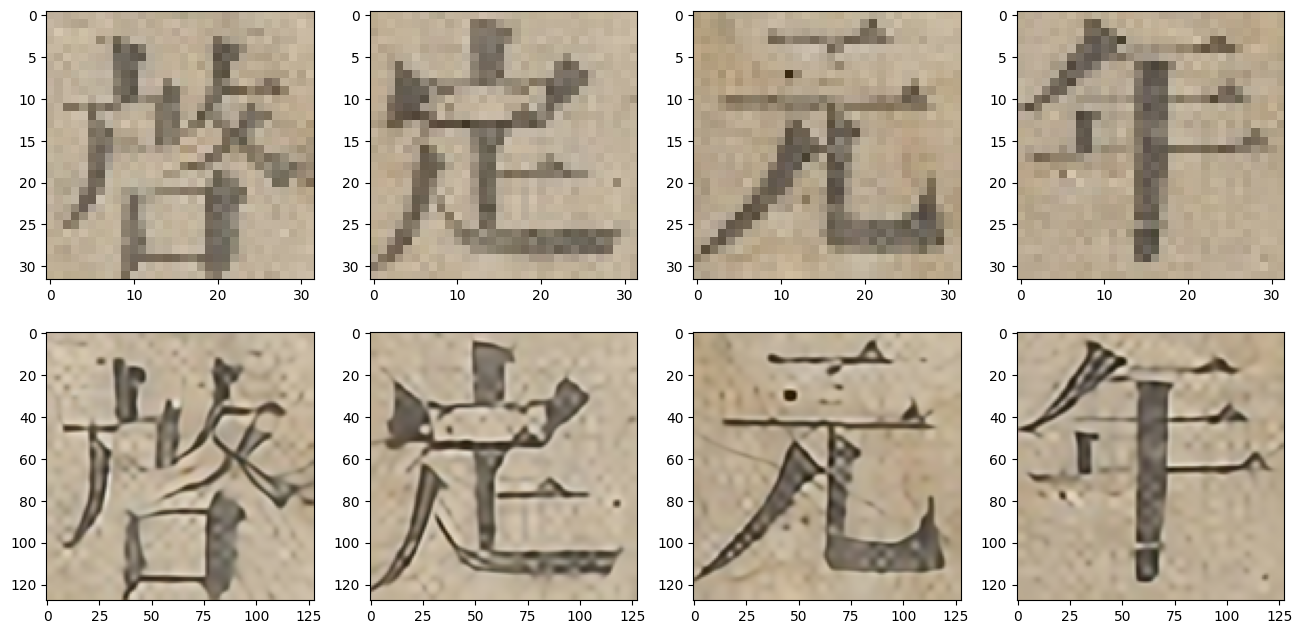

In [53]:
sr_model.to(DEVICE)
recognizer_model.to(DEVICE)

DATASET_NAME = 'LVT'
dataset = NomImageDataset(
    image_dir = f'/content/dataset/{DATASET_NAME}_crops/{DATASET_NAME}_crops',
    annotation_file = f'/content/dataset/{DATASET_NAME}_crops/LVT_crop.txt',
    unicode_dict_path = UCODE_DICT,
    # scale=SCALE,
    image_size=(32, 32),
    transform = None,
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)

label_dict = dict()
with open(UCODE_DICT, 'rb') as f:
    tmp = pickle.load(f)
for idx, (k, v) in enumerate(tmp.items()):
    label_dict[idx] = k

sample = next(iter(dataloader))
plt.figure(figsize=(16, 16))
for i in range(4):
    plt.subplot(4, 4, i+1)
    img = sample[0][i].permute(1, 2, 0).numpy() * 255
    plt.imshow(sample[0][i].permute(1, 2, 0).numpy())


    with torch.no_grad():
        sr_img = sr_model(sample[0][i].unsqueeze(0).to(DEVICE)).squeeze().cpu().detach().permute(1, 2, 0).numpy()[:, :, :3]


    print(sr_img.shape)
    # Take first 3 channel
    plt.subplot(4, 4, i+5)
    plt.imshow(sr_img)

    # plt.title(sample[1][i].item())
    try:
        print(chr(int(label_dict[sample[1][i].item()], 16)), end=' ')
    except:
        print('UNK', end=' ')

    # break
plt.show()


## Test on Raw images

In [47]:
torch.cuda.empty_cache()
sr_model.to(DEVICE)
recognizer_model.to(DEVICE)

pbar = tqdm(total=len(dataloader), desc='Testing')

correct_pred = 0
incorrect_pred = []
for idx, (imgs, labels) in enumerate(dataloader, 1):
    imgs = imgs.to(DEVICE)
    labels = labels.to(DEVICE)

    with torch.no_grad():
        # Essentially normal Resnet operation is inference on bicubic upscaled images
        bicubic_imgs = F.interpolate(imgs, size=(224, 224), mode='bicubic')
        bicubic_imgs = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(bicubic_imgs)


        preds = recognizer_model(bicubic_imgs)
        preds = F.softmax(preds, dim=1)
        preds = torch.argmax(preds, dim=1)

        correct_pred += torch.sum(preds == labels).item()
        # Record failure cases
        for i, (pred, label) in enumerate(zip(preds, labels)):
            if pred != label:
                incorrect_pred.append((f'{idx}_{i}', pred, label))
        pbar.update(1)

pbar.close()
print("\nAccuracy:", correct_pred / len(dataset))

Testing:   0%|          | 0/452 [00:00<?, ?it/s]


Accuracy: 0.7286505190311419


## Test on SR images

In [54]:
torch.cuda.empty_cache()
sr_model.to(DEVICE)
recognizer_model.to(DEVICE)
pbar = tqdm(total=len(dataloader), desc='Testing')

correct_pred = 0
incorrect_pred = []
for idx, (imgs, labels) in enumerate(dataloader, 1):
    imgs = imgs.to(DEVICE)
    labels = labels.to(DEVICE)

    with torch.no_grad():
        sr_imgs = sr_model(imgs)

        sr_imgs = F.interpolate(sr_imgs, size=(224, 224), mode='bicubic')
    # print(sr_imgs.shape)
        sr_imgs = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(sr_imgs)


        preds = recognizer_model(sr_imgs)
        preds = F.softmax(preds, dim=1)
        preds = torch.argmax(preds, dim=1)

        correct_pred += torch.sum(preds == labels).item()
    # Record failure cases
        for i, (pred, label) in enumerate(zip(preds, labels)):
            if pred != label:
                incorrect_pred.append((f'{idx}_{i}', pred, label))
    pbar.update(1)

pbar.close()
print("\nAccuracy:", correct_pred / len(dataset))


Testing:   0%|          | 0/452 [00:00<?, ?it/s]


Accuracy: 0.43868512110726643
